In [2]:
#pip install torch torchvision torchaudio

In [3]:
#pip -q install torchxrayvision

In [17]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
import torchxrayvision as xrv
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,  WeightedRandomSampler
from torchvision import datasets, models, transforms
import time
from torchsummary import summary
from sklearn.metrics import recall_score, accuracy_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

##Baixando dados

In [6]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset

fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.


In [9]:
data = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",csvpath="covid-chestxray-dataset/metadata.csv")

In [10]:
data

{'Aspergillosis': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Aspiration': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Bacterial': {np.float32(0.0): 487, np.float32(1.0): 48},
 'COVID-19': {np.float32(0.0): 193, np.float32(1.0): 342},
 'Chlamydophila': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Fungal': {np.float32(0.0): 512, np.float32(1.0): 23},
 'H1N1': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Herpes ': {np.float32(0.0): 532, np.float32(1.0): 3},
 'Influenza': {np.float32(0.0): 531, np.float32(1.0): 4},
 'Klebsiella': {np.float32(0.0): 526, np.float32(1.0): 9},
 'Legionella': {np.float32(0.0): 526, np.float32(1.0): 9},
 'Lipoid': {np.float32(0.0): 527, np.float32(1.0): 8},
 'MERS-CoV': {np.float32(0.0): 527, np.float32(1.0): 8},
 'MRSA': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Mycoplasma': {np.float32(0.0): 530, np.float32(1.0): 5},
 'No Finding': {np.float32(0.0): 520, np.float32(1.0): 15},
 'Nocardia': {np.float32(0.0): 531, np.float32(1.0): 4},
 'Pneumocystis': 

COVID19_Dataset num_samples=535 views=['PA', 'AP'] data_aug=None

In [11]:
df = data.csv

In [12]:
labels = []
imgs = []

for i in range(len(data)):
    pd.Series(dict(zip(data.pathologies,data[i]["lab"])))
    labels.append(pd.Series(dict(zip(data.pathologies,data[i]["lab"]))))
    imgs.append(data[i]["img"])

labels = pd.DataFrame(labels)
imgs = [i[0] for i in imgs]

In [13]:
# prompt: encontrar casos onde todos os registros são 0

zeros = []
for index, row in labels.iterrows():
    if row.sum() == 0:
        zeros.append(index)
print(f"Indices where all records are zero: {zeros}")

Indices where all records are zero: []


In [14]:
labels = labels['COVID-19']

In [15]:
labels.value_counts()

COVID-19
1.0    342
0.0    193
Name: count, dtype: int64

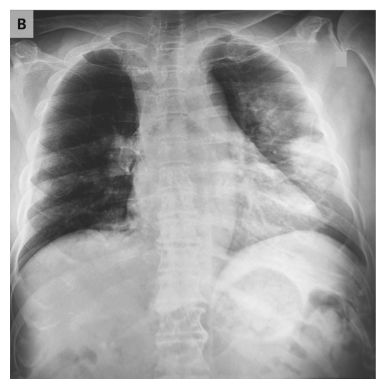

In [16]:
plt.imshow(imgs[1], cmap='gray')
plt.axis('off')
plt.show()

In [18]:
label_map = {
    0: 'Non-COVID',
    1: 'COVID-19'
}

In [19]:
base_dir = 'chestxray'
for split in ['train', 'val', 'test']:
    for label in label_map.values():
        os.makedirs(os.path.join(base_dir, split, label), exist_ok=True)

In [20]:
X_temp, X_test, y_temp, y_test = train_test_split(imgs, labels, test_size=0.15, stratify=labels, random_state=12)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.12, stratify=y_temp, random_state=33)

In [21]:
def save_images(img_list, label_list, split):
    for i, (img, label) in enumerate(zip(img_list, label_list)):
        folder = os.path.join(base_dir, split, label_map[label])

        # Se for numpy array float, converte para uint8 [0-255]
        if isinstance(img, np.ndarray):
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)
            img = Image.fromarray(img)

        # Se for imagem PIL, mas em modo float, converte para RGB (ou L, dependendo do caso)
        elif img.mode == 'F':
            img = img.convert('RGB')  # ou 'L' para grayscale

        img.save(os.path.join(folder, f"{split}_{i}.png"))

In [22]:
save_images(X_train, y_train, 'train')
save_images(X_val, y_val, 'val')
save_images(X_test, y_test, 'test')

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Funções gerais

In [38]:
# Applying Transforms to the Data
# pre-trained models expect data with the same pre processing as data it was originally trained on
# thus those transformations are necessary
# + a bit of data augmentation
# podem resizes de tamanhos diferentes?
image_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3), #xrays are b&w but densenet expects rgb
        transforms.Resize(256),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        #transforms.RandomResizedCrop(size=332, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=5),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(), #image (format PIL) -> tensor (format pytorch)
        #normalizar por 255 - ToTensor já faz isso automatico
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    #val and test's transformations are deterministic (no noise, no diversity generated)
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [39]:
dataset = 'chestxray'
train_directory = os.path.join(dataset, 'train') #chestxray/train
val_directory = os.path.join(dataset, 'val') #chestxray/val
test_directory = os.path.join(dataset, 'test') #chestxray/test

In [215]:
#essas redes foram treinadas em imagens preto e branco, logo, 1 canal. até agora, estava usando transformacoes que expandiam nossas imagens p&b pra rgb
#(como descongelei a camada convolucional - no fine tuning - , então o número de canais precisa coincidir com o que foi treinado)
#ent preciso refazer essa parte do processamento, chamando a funcao que não expande o número de canais
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'val': datasets.ImageFolder(root=val_directory, transform=image_transforms['val']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

train_data_size = len(data['train'])
val_data_size = len(data['val'])
test_data_size = len(data['test'])

train_data_loader_for_custom_networks = DataLoader(data['train'], batch_size=50, shuffle=True) #not learning sequences here
val_data_loader_for_custom_networks = DataLoader(data['val'], batch_size=50, shuffle=False)
test_data_loader_for_custom_networks = DataLoader(data['test'], batch_size=50, shuffle=False)

# train_targets = [label for _, label in data['train'].imgs]
# class_sample_counts = np.bincount(train_targets)
# class_weights = 1. / class_sample_counts
# sample_weights = [class_weights[label] for label in train_targets]
# sample_weights = torch.DoubleTensor(sample_weights)
# sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# train_data_loader = DataLoader(data['train'], batch_size=24, sampler=sampler) 
# val_data_loader = DataLoader(data['val'], batch_size=30, shuffle=False)
# test_data_loader = DataLoader(data['test'], batch_size=32, shuffle=False)

{0: 'COVID-19', 1: 'Non-COVID'}


In [ ]:
#queremos maximizar recall normal (da classe zero)

In [166]:
def train_and_validate(model, loss_criterion, optimizer, epochs, dataset="chestxraytry",
                       train_data_loader=train_data_loader, val_data_loader=val_data_loader, train_data_size=train_data_size,
                       val_data_size=val_data_size, device=device):
    
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        #print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        # Para armazenar labels e previsões da validação
        all_val_labels = []
        all_val_predictions = []

        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = loss_criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():
            model.eval()

            for j, (inputs, labels) in enumerate(val_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                loss = loss_criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)

                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_predictions.extend(predictions.cpu().numpy())

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / val_data_size
        avg_valid_acc = valid_acc / val_data_size

        # Calcular métricas usando sklearn
        recall_majority = recall_score(all_val_labels, all_val_predictions, pos_label=1)
        sensitivity_minority = recall_score(all_val_labels, all_val_predictions, pos_label=0)
        accuracy = accuracy_score(all_val_labels, all_val_predictions)

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc, recall_majority])

        epoch_end = time.time()
        print("\nEpoch {}/{}: {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t      Validation: Loss - {:.4f}, Accuracy - {:.4f}% \nRecall (COVID) - {:.4f}, Sensitivity (SEM COVID) - {:.4f}, Time: {:.4f}s".format(
    epoch+1, epochs, epoch, avg_train_loss, avg_train_acc * 100, avg_valid_loss, avg_valid_acc * 100, recall_majority, sensitivity_minority, epoch_end - epoch_start))
        #torch.save(model, dataset + '_model_' + str(epoch) + '.pt')

    return model, history, best_epoch

In [42]:
def computeTestSetPerformance(model, loss_criterion, device):
    # Function to compute the accuracy on the test set

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0
    test_true_positives = 0.0
    test_false_negatives = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # for each batch in test
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            test_acc += acc.item() * inputs.size(0)
            test_true_positives += ((predictions == 1) & (labels == 1)).sum().item()
            test_false_negatives += ((predictions == 0) & (labels == 1)).sum().item()

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy and recall
    avg_test_loss = test_loss/test_data_size
    avg_test_acc = test_acc/test_data_size
    test_recall = test_true_positives / (test_true_positives + test_false_negatives + 1e-7)

    print("Test accuracy : " + str(avg_test_acc))


In [43]:
def predict(model, test_image_name):
    #Function to predict the class of a single test image

    transform = image_transforms['test'] #loads pre processing needed into test images in 'transform' object
    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    test_image_tensor = transform(test_image) #applies the processing

    if torch.cuda.is_available():
      #view regorganized tensor so its format is (batch size X number of channels X height X depth)
        #test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
        #unsqueeze(dim) adds dimension of size 1 at position dim
        test_image_tensor = test_image_tensor.unsqueeze(0).cuda()
    else:
        #test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
        test_image_tensor = test_image_tensor.unsqueeze(0)

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor) #model outputs (probabilities for each class)
        #ps = torch.exp(out) #for LogSoftMax activation

        topk, topclass = out.topk(1, dim=1) #most likely class
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]
        score = topk.cpu().numpy()[0][0]
        print("Prediction:", cls, ", with probability:", score) #shows most likely class

##rede

In [34]:
#print(mobilenet)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [102]:
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.68)

In [257]:
mobilenet2 = models.mobilenet_v2(pretrained=True)
mobilenet2.classifier[1] = nn.Linear(mobilenet.last_channel, 2)

In [258]:
for param in mobilenet2.features.parameters():
    param.requires_grad = False  

for param in mobilenet2.classifier.parameters():
    param.requires_grad = True 

In [271]:
for param in mobilenet2.features[-3:].parameters(): 
    param.requires_grad = True

In [260]:
# class_counts = np.bincount(train_targets)
# class_weights = 1. / np.sqrt(class_counts)
# class_weights = class_weights / class_weights.sum()

# weights = torch.FloatTensor(class_weights).to(device)
loss_func = nn.CrossEntropyLoss()

In [272]:
optimizer = torch.optim.Adam([p for p in mobilenet2.parameters() if p.requires_grad], lr=8e-7)

In [273]:
num_epochs = 40
trained_model, history, best_epoch = train_and_validate(mobilenet2, loss_func, optimizer, num_epochs)


Epoch 1/40: 000, Training: Loss - 0.7147, Accuracy - 46.1153%, 
	      Validation: Loss - 0.6917, Accuracy - 61.8182% 
Recall (COVID) - 0.0000, Sensitivity (SEM COVID) - 0.9714, Time: 53.3980s

Epoch 2/40: 001, Training: Loss - 0.7077, Accuracy - 51.3784%, 
	      Validation: Loss - 0.6980, Accuracy - 63.6364% 
Recall (COVID) - 0.0000, Sensitivity (SEM COVID) - 1.0000, Time: 54.4161s

Epoch 3/40: 002, Training: Loss - 0.6962, Accuracy - 52.8822%, 
	      Validation: Loss - 0.7031, Accuracy - 63.6364% 
Recall (COVID) - 0.0000, Sensitivity (SEM COVID) - 1.0000, Time: 52.5465s

Epoch 4/40: 003, Training: Loss - 0.6861, Accuracy - 52.3810%, 
	      Validation: Loss - 0.7030, Accuracy - 63.6364% 
Recall (COVID) - 0.0000, Sensitivity (SEM COVID) - 1.0000, Time: 53.1367s

Epoch 5/40: 004, Training: Loss - 0.7041, Accuracy - 46.1153%, 
	      Validation: Loss - 0.6910, Accuracy - 63.6364% 
Recall (COVID) - 0.0000, Sensitivity (SEM COVID) - 1.0000, Time: 53.3775s

Epoch 6/40: 005, Training: Lo

KeyboardInterrupt: 

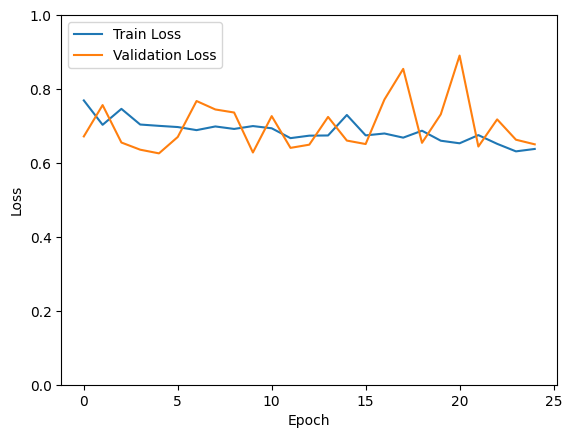

In [263]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.show()

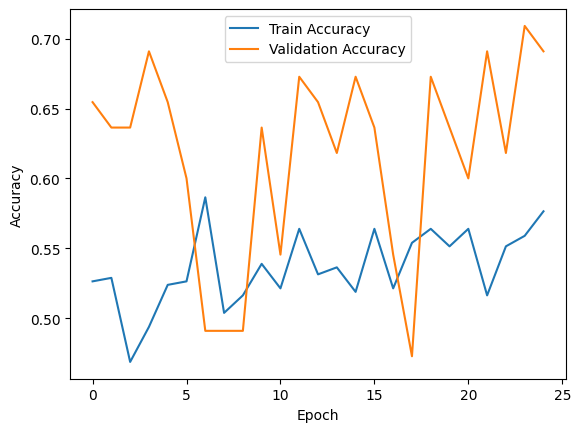

In [264]:
plt.plot(history[:,2:4])
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()